# **Alzheimer's MRI Image Classification Model**

# **Introduction**

Alzheimer's is a progressive disease that results in mild memory loss but can result in the inability to respond to an environment.Alzheimer's is the most common form of dementia. This results in a huge problem for the aging population that needs to be addressed. Changes in the brain can appear years before symptoms present themselves. Thus, catching these changes and addressing the problem early would be incredibly useful. Artificial intelligence can be used in this way to predict whether a patient will experience Alzheimer's.

This project will use a custom convolutional net from RadImageNet to predict level of dementia of a patient, classifying them into 'Non-demented', 'Very mild demented', 'Mild demented' and 'Moderate Demented'. The Alzheimer MRI Disease Classification Dataset from author Falah.G.Salieh will be used to train and validate the models.

****

In [34]:
import os
count=0
for dirname, _, filenames in os.walk('C:/Users/USER/Desktop/DataScience/AlzheimerMRIDiseaseClassification/AlzheimerMRIDiseaseClassificationDataset/Data/'):
    for filename in filenames:
        if count==0:
            test_data_file_path=os.path.join(dirname, filename)
            count+=1
        else:
            train_data_file_path=os.path.join(dirname, filename)
        print(os.path.join(dirname, filename))

C:/Users/USER/Desktop/DataScience/AlzheimerMRIDiseaseClassification/AlzheimerMRIDiseaseClassificationDataset/Data/test.parquet
C:/Users/USER/Desktop/DataScience/AlzheimerMRIDiseaseClassification/AlzheimerMRIDiseaseClassificationDataset/Data/train.parquet


## Import Data and Libraries

In [35]:
import math, re, os, warnings
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model


import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing import image_dataset_from_directory

import time

import warnings
warnings.filterwarnings('ignore')

In [36]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.0


### Import data

**Set matplotlib defaults**

In [37]:
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore") # to clean up output cells

In [38]:
# Specify file paths

##test_data_file_path ='C:\\Users\\USER\\Desktop\\DataScience\\Sem7projects\\AlzheimerMRIDiseaseClassificationDataset\\Data\\test.parquet'

# Read data in

train_data = pd.read_parquet(train_data_file_path)
test_data = pd.read_parquet(test_data_file_path)

Turning byte format into img

In [39]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
        return img

In [40]:
train_data['image'] = train_data['image'].apply(dict_to_image)
test_data['image'] = test_data['image'].apply(dict_to_image)

In [41]:
train_data.head()

,image,label
0,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
3,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
4,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",2


In [42]:
train_data['image'][0]

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

**Split training data to get validation set**

In [43]:
X = train_data['image']
y = train_data['label']

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.75, random_state=10)

In [44]:
X_test = test_data['image']
y_test = test_data['label']

Rejoin data into one dataframe

In [45]:
# Training data

X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
train_df = pd.concat([X_train_df, y_train_df], axis=1)

# Validation data

X_val_df = pd.DataFrame(X_val)
y_val_df = pd.DataFrame(y_val)
val_df = pd.concat([X_val_df, y_val_df], axis=1)

In [46]:
# Test data
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)
test_df = pd.concat([X_test_df, y_test_df], axis=1)

****

# **Exploratory Data Analysis**

In [47]:
train_df.head()

,image,label
4338,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
788,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
13,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
2143,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",3
2893,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0


**We can explore some images**

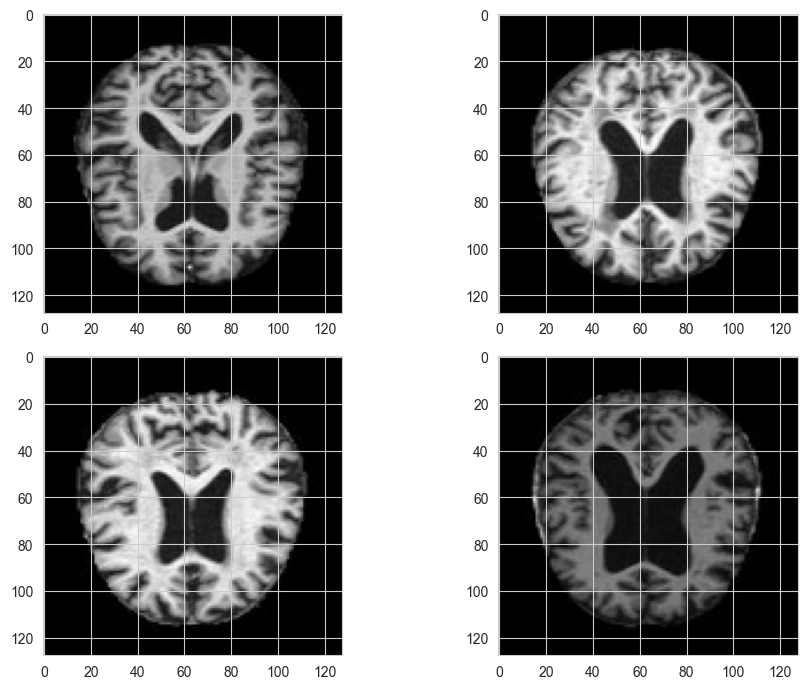

In [48]:
# Training images
mri_images = train_df['image']

fig = plt.figure(figsize=(10, 7)) 

for i in range(0, len(mri_images), 1000):
    n = int((i / 1000) + 1)
    
    fig.add_subplot(2,2,n)
    plt.imshow(mri_images.iloc[i])

plt.show()

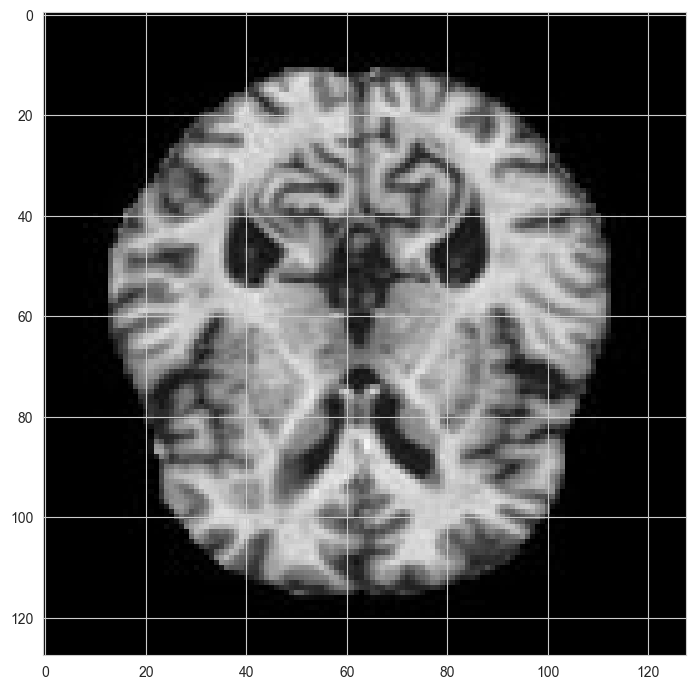

In [49]:
# Test images
mri_images_test = test_df['image']

fig = plt.figure(figsize=(10, 7)) 

for i in range(0, len(mri_images_test), 1000):
    n = int((i / 1000) + 1)
    
    #fig.add_subplot(2,2)
    plt.imshow(mri_images_test.iloc[i])

plt.show()

Lets check the count of each label

In [50]:
labels = train_data['label']
label_counts = pd.DataFrame(labels.value_counts())
label_counts.index = ['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented']
label_counts

,label
Non Demented,2566
Very Mild Demented,1781
Mild Demented,724
Moderate Demented,49


In [51]:
pd.DataFrame(labels.value_counts())

,label
2,2566
3,1781
0,724
1,49


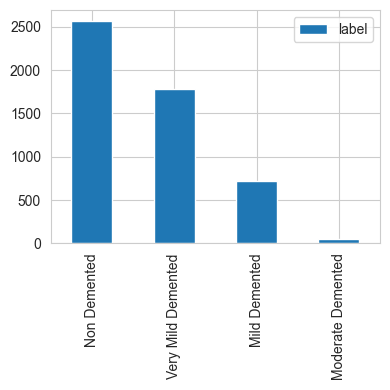

In [52]:
label_plot = label_counts.plot.bar()
plt.show()

There is a very clear class imbalance. With hardly any Moderate Demented and Mild Demented images, it will be well worth it to perform data augmentation to increase the class sizes.

Create scatterplot to view the classification plot

In [53]:
#plt.scatter(train_df.image[:,0], train_df.image[:,1], c='label', cmap=plt.cm.RdYlBu)

****

# **Preprocessing**

### Reshape images

In [54]:
from tensorflow.keras.utils import to_categorical

# Define reshape function
def reshape_X_y(X, y):
    X_array = []
    for x in X:
        X_array.append(x)
    
    y = to_categorical(y)

    # Normalisation
    X_array = np.array(X_array)
    X_array = X_array / 255.0
    
    y = np.array(y)
    
    print(X_array.shape, y.shape)
    return X_array, y

# Training data
X_train_ds, y_train_ds = reshape_X_y(X_train, y_train)

# Validation data
X_val_ds, y_val_ds = reshape_X_y(X_val, y_val)

# Test data
X_test_ds, y_test_ds = reshape_X_y(X_test, y_test)

(3840, 128, 128, 3) (3840, 4)
(1280, 128, 128, 3) (1280, 4)
(1280, 128, 128, 3) (1280, 4)


### Define class names

In [55]:
class_names = np.array(['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented'])
print(class_names)

['Non Demented' 'Very Mild Demented' 'Mild Demented' 'Moderate Demented']


****

# **Model building**

## Defining Baseline Model Architectures

*We are going to create a custom convnet model

### Model 1: *Custom convolutional net*

In [56]:
model1 = keras.Sequential([
    
    # First Block
    layers.Conv2D(kernel_size=3, filters=32, input_shape=([128, 128, 3]), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Second Block
    layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    # Classifier Head
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(epsilon=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [57]:
start = time.time()

history1 = model1.fit(X_train_ds, y_train_ds,
                      steps_per_epoch=len(X_train_ds),
                      batch_size=32,
                      validation_data=(X_val_ds, y_val_ds),
                      validation_steps=len(X_val_ds),
                      epochs=40
)

print('It takes %s minutes' % ((time.time() - start)/60))

Epoch 1/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.4987 - loss: 1.0230 - val_accuracy: 0.5000 - val_loss: 0.9820
Epoch 2/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - accuracy: 0.5477 - loss: 0.9435 - val_accuracy: 0.5175 - val_loss: 0.9160
Epoch 3/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.5742 - loss: 0.9064 - val_accuracy: 0.5968 - val_loss: 0.9111
Epoch 4/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.6198 - loss: 0.8300 - val_accuracy: 0.5495 - val_loss: 0.8682
Epoch 5/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 48s 13ms/step - accuracy: 0.6411 - loss: 0.7801 - val_accuracy: 0.6349 - val_loss: 0.7386
Epoch 6/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - accuracy: 0.7395 - loss: 0.6238 - val_accuracy: 0.7088 - val_loss: 0.6114
Epoch 7/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - accuracy: 0.8117 - loss: 0.4745 - val_accuracy: 0.7485 - val_loss: 0.5078
Epoch 8/40
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 82s 12ms/step - accuracy: 0.8603 - 

In [58]:
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │       4,194,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,642,062 (48.23 MB)

 Trainable params: 4,214,020 (16.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,428,042 (32.15 MB)

In [59]:
history1_plot = pd.DataFrame(history1.history)
history1_plot.head(10)

,accuracy,loss,val_accuracy,val_loss
0,0.498709,1.021688,0.500000,0.981987
1,0.547779,0.943034,0.517531,0.915957
2,0.574380,0.905760,0.596799,0.911115
3,0.619835,0.829189,0.549543,0.868164
4,0.641529,0.779074,0.634909,0.738641
5,0.739928,0.622747,0.708841,0.611408
6,0.811467,0.474193,0.748476,0.507835
7,0.860279,0.340023,0.804116,0.437383
8,0.895403,0.269823,0.860518,0.313627
9,0.935950,0.173135,0.849085,0.299601


## **Evaluation of baseline models**

In [60]:
plt.rcParams['figure.figsize'] = [4, 4]

### Model 1: *Custom Convnet*

**Validation loss**

(0.0, 1.0)

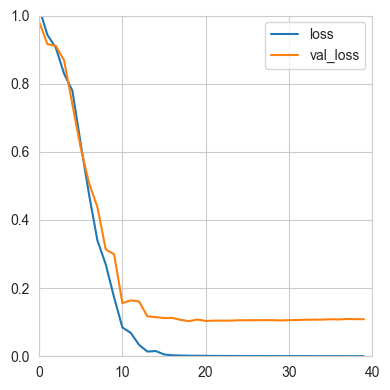

In [61]:
history1_plot.loc[:,['loss', 'val_loss']].plot()
plt.xlim(0, 40)
plt.ylim(0, 1)

**Validation Accuracy**

(0.0, 1.0)

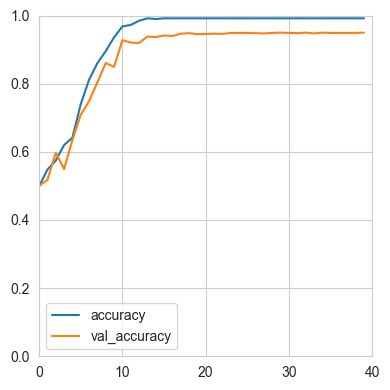

In [62]:
history1_plot.loc[:,['accuracy', 'val_accuracy']].plot()
plt.xlim(0, 40)
plt.ylim(0, 1)

In [68]:
y_pred = model1.predict(X_test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax output to class labels
y_test_classes = np.argmax(y_test_ds, axis=1)  # Convert one-hot encoded test labels to class labels
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
Test Accuracy: 95.94%


In [63]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Set your folder path here
folder_path = 'C:/Users/USER/Desktop/DataScience/AlzheimerMRIDiseaseClassification/AlzheimerMRIDiseaseClassificationDataset/predict_data'  # Replace with your folder path

# List to store predictions
predictions_list = []

# Loop over each image file in the folder
for image_name in os.listdir(folder_path):
    if image_name.endswith('.jpg'):
        # Load and preprocess the image
        img_path = os.path.join(folder_path, image_name)
        img = load_img(img_path, target_size=(128, 128))  # Resize to match model input
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize if done during training

        # Make a prediction
        predictions = model1.predict(img_array)  # Use model1 or your chosen model
        predicted_class = np.argmax(predictions, axis=1)  # Get index of highest probability

        # Map index to class name
        class_names = np.array(['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented'])
        predicted_label = class_names[predicted_class][0]

        # Store result
        predictions_list.append((image_name, predicted_label))

# Convert to a DataFrame for easier viewing
predictions_df = pd.DataFrame(predictions_list, columns=['Image Name', 'Predicted Class'])

# Display the predictions
print(predictions_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
                Image Name    Predicted Class
0          mild_sample.jpg  Moderate Demented
1      moderate_sample.jpg      Mild Demented
2  non_demented_sample.jpg  Moderate Demented
3   very_mild_demented.jpg  Moderate Demented


In [71]:
model1.save("model1.keras") 

****

#### Experiment 1: EarlyStopping and Precision

We are going to experiment with using EarlyStopping. Due to the unbalanced classes, it is also a bad idea to use accuracy, thus we will use precision as our metric. As a general rule, changing more than one parameter at a time is not advised, but the use of accuracy as a metric is unlikely to continue, regardless.

In [64]:
# 1. Build experiment 1

model1_1 = keras.Sequential([
    
    # First Block
    layers.Conv2D(kernel_size=3, filters=32, input_shape=([128, 128, 3]), activation='relu', padding='same'),
    layers.MaxPool2D(),
    
    
    # Second Block
    layers.Conv2D(filters=64, activation='relu', padding='same', kernel_size=3),
    layers.MaxPool2D(),
    
    # Output Layers
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=4, activation='softmax')
])

# 2. Compile experiment 1

model1_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss='categorical_crossentropy',
                metrics=['precision'])

# - Define Early Stopping

earlystop1_1 = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=10)

# 3. Fit experiment 1

history1_1 = model1_1.fit(X_train_ds, y_train_ds,
                steps_per_epoch=len(X_train_ds),
                validation_data=(X_val_ds, y_val_ds),
                validation_steps=len(X_val_ds),
                batch_size=32,
                epochs=100,
                callbacks=[earlystop1_1])

Epoch 1/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - loss: 1.0622 - precision: 0.5910 - val_loss: 0.8784 - val_precision: 0.6858
Epoch 2/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 46s 12ms/step - loss: 0.8491 - precision: 0.7016 - val_loss: 0.7981 - val_precision: 0.6828
Epoch 3/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - loss: 0.6763 - precision: 0.7561 - val_loss: 0.7151 - val_precision: 0.7126
Epoch 4/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 49s 13ms/step - loss: 0.4927 - precision: 0.8228 - val_loss: 0.5231 - val_precision: 0.7987
Epoch 5/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 45s 12ms/step - loss: 0.3316 - precision: 0.8837 - val_loss: 0.4200 - val_precision: 0.8291
Epoch 6/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - loss: 0.1907 - precision: 0.9371 - val_loss: 0.2597 - val_precision: 0.9044
Epoch 7/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step - loss: 0.1116 - precision: 0.9660 - val_loss: 0.2412 - val_precision: 0.9047
Epoch 8/100
3840/3840 ━━━━━━━━━━━━━━━━━━━━ 53s 14ms/ste

<AxesSubplot: >

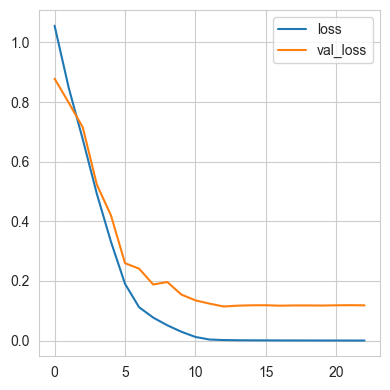

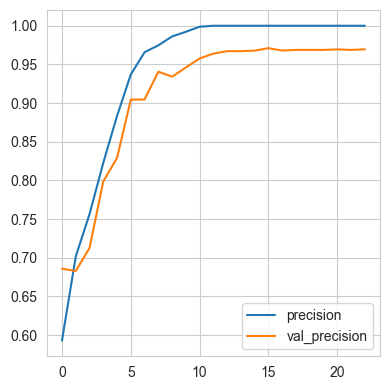

In [65]:
history1_1_plot = pd.DataFrame(history1_1.history)
history1_1_plot.loc[: , ['loss', 'val_loss']].plot()
history1_1_plot.loc[:, ['precision', 'val_precision']].plot()

In [69]:
y_pred = model1_1.predict(X_test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert softmax output to class labels
y_test_classes = np.argmax(y_test_ds, axis=1)  # Convert one-hot encoded test labels to class labels
from sklearn.metrics import accuracy_score

test_accuracy = accuracy_score(y_test_classes, y_pred_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step
Test Accuracy: 95.23%


In [66]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Set your folder path here
folder_path = 'C:/Users/USER/Desktop/DataScience/AlzheimerMRIDiseaseClassification/AlzheimerMRIDiseaseClassificationDataset/predict_data'  # Replace with your folder path

# List to store predictions
predictions_list = []

# Loop over each image file in the folder
for image_name in os.listdir(folder_path):
    if image_name.endswith('.jpg'):
        # Load and preprocess the image
        img_path = os.path.join(folder_path, image_name)
        img = load_img(img_path, target_size=(128, 128))  # Resize to match model input
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize if done during training

        # Make a prediction
        predictions = model1_1.predict(img_array)  # Use model1 or your chosen model
        predicted_class = np.argmax(predictions, axis=1)  # Get index of highest probability

        # Map index to class name
        class_names = np.array(['Non Demented', 'Very Mild Demented', 'Mild Demented', 'Moderate Demented'])
        predicted_label = class_names[predicted_class][0]

        # Store result
        predictions_list.append((image_name, predicted_label))

# Convert to a DataFrame for easier viewing
predictions_df = pd.DataFrame(predictions_list, columns=['Image Name', 'Predicted Class'])

# Display the predictions
print(predictions_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
                Image Name    Predicted Class
0          mild_sample.jpg      Mild Demented
1      moderate_sample.jpg  Moderate Demented
2  non_demented_sample.jpg       Non Demented
3   very_mild_demented.jpg      Mild Demented


In [72]:
model1_1.save("model1_1.keras") 

****

# **Analyses and Conclusion**

We found that the custom convolutional net outperformed. However, the lack of 'Moderate Demented' images proved to be troublesome. Augmentation was considered, however due to the nature of Alzheimers, altering the images could change the class and was considered too risky to achieve. Regardless, the custom convolutional net achieved fairly satisfactory results in good time, but overfit a bit. Further optimisation would be required before deployment. Future steps would include gathering more data, gaining more domain knowledge to learn ways to make more use of our current data as well as hyperpareameter tuning. A user-friendly interface for deployment could be considered as an extension as well.
The early stopping technique helped prevent overfitting, ensuring that the model generalizes well to new, unseen data. By stopping training at the optimal point, the model maintained high accuracy on the test set while avoiding unnecessary complexity. This approach improved the reliability of Alzheimer’s MRI classification, making it more effective for real-world applications.

****

# **References**


https://www.analyticsvidhya.com/blog/2021/05/tuning-the-hyperparameters-and-layers-of-neural-network-deep-learning/

https://medium.com/geekculture/eda-for-image-classification-dcada9f2567a

https://insightsimaging.springeropen.com/articles/10.1007/s13244-018-0639-9

https://towardsdatascience.com/loss-functions-and-their-use-in-neural-networks-a470e703f1e9

https://insightsimaging.springeropen.com/articles/10.1007/s13244-018-0639-9

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8321322/

https://medium.com/@thecybermarty/multi-class-activation-functions-df969651d4c5#:~:text=Softmax%20is%20the%20most%20commonly,make%20decisions%20based%20on%20them.
